#Final_Version for Hang, Hanyu, and Jady

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score

*Import data*

In [2]:
dtypes={
    'elapsed_time':np.int32,
    'event_name':'category',
    'name':'category',
    'level':np.uint8,
    'room_coor_x':np.float32,
    'room_coor_y':np.float32,
    'screen_coor_x':np.float32,
    'screen_coor_y':np.float32,
    'hover_duration':np.float32,
    'text':'category',
    'fqid':'category',
    'room_fqid':'category',
    'text_fqid':'category',
    'fullscreen':'category',
    'hq':'category',
    'music':'category',
    'level_group':'category'}

train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', dtype=dtypes)
labels = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')

In [3]:
train.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991394,-159.314682,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991394,-159.314682,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [4]:
train['session_id'].unique().shape
# check the number of users

(23562,)

In [5]:
train.shape

(26296946, 20)

In [6]:
# get rid of the "_qx" in the session_id
labels['session'] = labels.session_id.apply(lambda x: int(x.split('_')[0]) )
labels['q'] = labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

In [7]:
# choose appropriate categorical features and numerical features
cat_features = ['event_name', 'name','fqid', 'room_fqid', 'text_fqid']
num_features = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
       'screen_coor_x', 'screen_coor_y', 'hover_duration']

# cat_features = ['fqid', 'room_fqid']
# num_features = ['level', 'page', 'screen_coor_x', 'screen_coor_y', 'hover_duration']


In [8]:
# Reference: https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664/notebook

# add more features to the data
def feature_engineer(dataset_df):
    dfs = []
    for c in cat_features:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in num_features:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in num_features:
        tmp = dataset_df.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    dataset_df = pd.concat(dfs,axis=1)
    dataset_df = dataset_df.fillna(-1)
    dataset_df = dataset_df.reset_index()
    dataset_df = dataset_df.set_index('session_id')
    return dataset_df

In [9]:
train = feature_engineer(train)

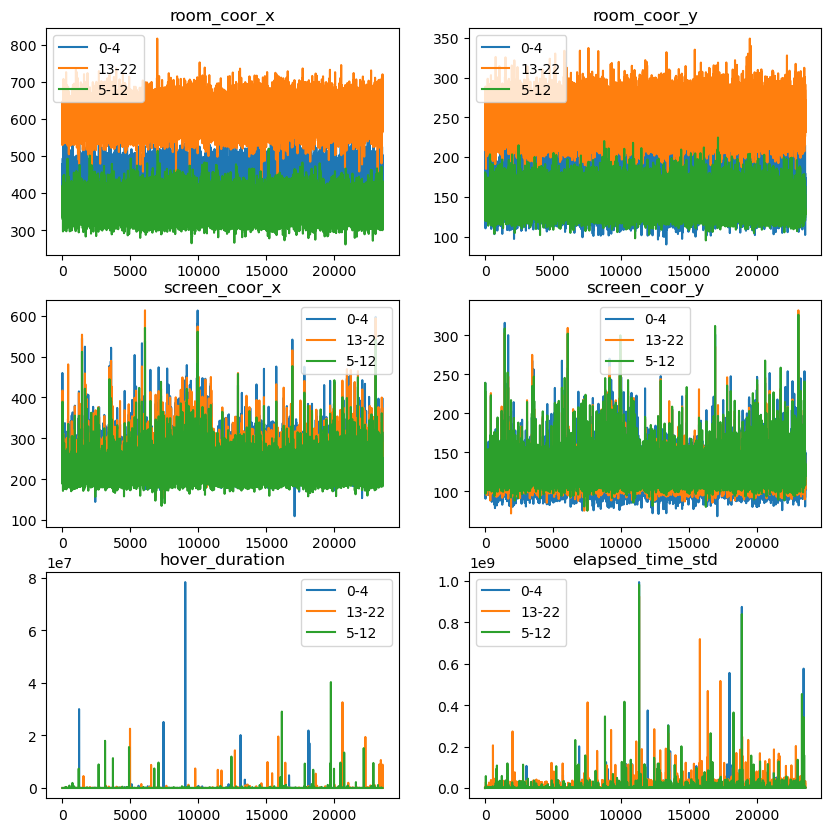

In [10]:
# Visualization of the data

figure, axis = plt.subplots(3, 2, figsize=(10, 10))

for name, data in train.groupby('level_group'):
    axis[0, 0].plot(range(1, len(data['room_coor_x_std'])+1), data['room_coor_x_std'], label=name)
    axis[0, 1].plot(range(1, len(data['room_coor_y_std'])+1), data['room_coor_y_std'], label=name)
    axis[1, 0].plot(range(1, len(data['screen_coor_x_std'])+1), data['screen_coor_x_std'], label=name)
    axis[1, 1].plot(range(1, len(data['screen_coor_y_std'])+1), data['screen_coor_y_std'], label=name)
    axis[2, 0].plot(range(1, len(data['hover_duration'])+1), data['hover_duration_std'], label=name)
    axis[2, 1].plot(range(1, len(data['elapsed_time_std'])+1), data['elapsed_time_std'], label=name)
    

axis[0, 0].set_title('room_coor_x')
axis[0, 1].set_title('room_coor_y')
axis[1, 0].set_title('screen_coor_x')
axis[1, 1].set_title('screen_coor_y')
axis[2, 0].set_title('hover_duration')
axis[2, 1].set_title('elapsed_time_std')

for i in range(3):
    axis[i, 0].legend()
    axis[i, 1].legend()

plt.show()

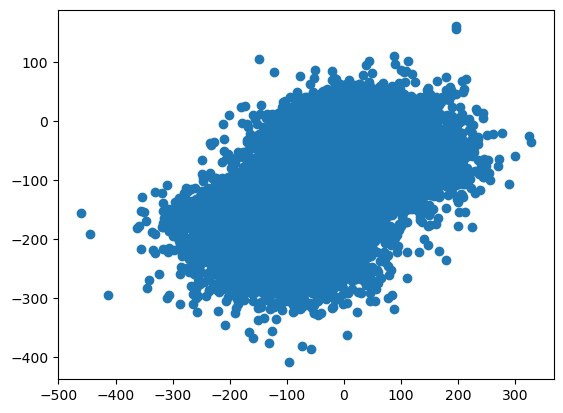

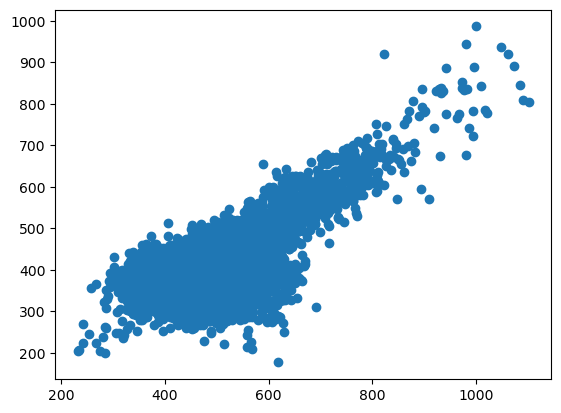

In [11]:
plt.scatter(train['room_coor_x'], train['room_coor_y'])
plt.show()

plt.scatter(train['screen_coor_x'], train['screen_coor_y'])
plt.show()

In [12]:
train.shape

(70686, 22)

In [13]:
# filter outliers of room coordinates
index_room_filter = train[ (train['room_coor_y'] >= 100) | (train['room_coor_y'] <= -380) 
                          | (train['room_coor_x'] <= -400)].index
print("Drop",len(index_room_filter), "outliers of room coordinates")
train.drop(index_room_filter, inplace=True)

Drop 12 outliers of room coordinates


In [14]:
# split the dataset according to the users
def split_dataset(dataset, test_ratio=0.20):
    USER_LIST = train.index.unique()
    split = int(len(USER_LIST) * (1 - 0.20))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]]

train_x, valid_x = split_dataset(train)
print("{} examples in training, {} examples in testing.".format(
    len(train_x), len(valid_x)))
print("Training data size is",train_x.shape[0])
print("Validating data size is",valid_x.shape[0])

56523 examples in training, 14133 examples in testing.
Training data size is 56523
Validating data size is 14133


In [15]:
# create a dataframe to store the result
adict = {}
for i in range(1,19):
    adict[i] = 0
result_df = pd.DataFrame(adict ,index=valid_x.index.unique())

Tried Tree_Test and other ways, keep the Best XGB

# **XGB Test**

In [16]:
FEATURES = [f for f in train.columns if f != 'level_group']
models={}
Acc = []
F1 = []
for q_num in range(1,19):
    # iterate through 18 questions    
    
    # classify the questions upon the level group  
    if q_num<=3: grp = '0-4'
    elif q_num<=13: grp = '5-12'
    elif q_num<=22: grp = '13-22'

    # Train data
    train_df = train_x.loc[train_x.level_group == grp]
    train_users = train_df.index.values
    train_labels = labels.loc[labels.q==q_num].set_index('session').loc[train_users]
    
    # Valid data
    valid_df = valid_x.loc[valid_x.level_group == grp]
    valid_users = valid_df.index.values
    valid_labels = labels.loc[labels.q==q_num].set_index('session').loc[valid_users]
    
    # Add the label to the filtered datasets.
    train_df["correct"] = train_labels["correct"]
    valid_df["correct"] = valid_labels["correct"]
    
    # set up the XGB parameters
    xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 1000,
    'early_stopping_rounds': 40,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4}
    estimator = XGBClassifier(**xgb_params)
    
    # train the XGB model
    X = train_df[FEATURES].astype('float32')
    Y = train_df['correct']
    estimator.fit(X,Y,
                eval_set=[ (valid_df[FEATURES].astype('float32'), valid_df['correct']) ],
                verbose=0)
    
#     grid_search.fit(train_df[FEATURES].astype('float32'), train_df['correct'],
#                 eval_set=[ (valid_df[FEATURES].astype('float32'), valid_df['correct']) ],
#                 verbose=0)
    
    print("Question",q_num,"Done")
    
    # save the model, its prediction result, current accuracy
    predictions=estimator.predict(valid_df[FEATURES])
    accuracy = accuracy_score(valid_df['correct'], predictions)
    Acc.append(accuracy)
    f1 = f1_score(valid_df['correct'], predictions, average='macro')
    F1.append(f1)
    
    models[f'{grp}_{q_num}'] = estimator
    result_df.loc[valid_users, q_num-1] = estimator.predict_proba(valid_df[FEATURES].astype('float32'))[:,1]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Question 1 Done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Question 2 Done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Question 3 Done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Question 4 Done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Question 5 Done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Question 6 Done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Question 7 Done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Question 8 Done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Question 9 Done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Question 10 Done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Question 11 Done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Question 12 Done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Question 13 Done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Question 14 Done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Question 15 Done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Question 16 Done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Question 17 Done


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Question 18 Done


In [17]:
for i in range(18):
    print("F1 for Question",i, "is",F1[i])

print()
print("Overall average F1 is",np.mean(F1))

F1 for Question 0 is 0.4438185204602548
F1 for Question 1 is 0.4938218545181046
F1 for Question 2 is 0.4832163229486617
F1 for Question 3 is 0.5054255774278446
F1 for Question 4 is 0.6117859774304882
F1 for Question 5 is 0.5065157118793263
F1 for Question 6 is 0.47316076090452786
F1 for Question 7 is 0.45516087685899004
F1 for Question 8 is 0.5244558235142973
F1 for Question 9 is 0.6071430775149905
F1 for Question 10 is 0.48688925644358794
F1 for Question 11 is 0.4652060392780111
F1 for Question 12 is 0.4777105111786154
F1 for Question 13 is 0.5190158138258322
F1 for Question 14 is 0.6157889301345776
F1 for Question 15 is 0.42841543314729436
F1 for Question 16 is 0.41372627468096423
F1 for Question 17 is 0.4876563349646547

Overall average F1 is 0.499939616506168


In [18]:
# modify the threshold to fit this imbalanced dataset
true = result_df.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = labels.loc[labels.q == k+1].set_index('session').loc[valid_x.index.unique()]
    true[k] = tmp.correct.values
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; 
thresholds = []
best_score = 0; 
best_threshold = 0

threshold = 0.4

while True:
    if threshold > 0.6:
        break
    
    preds = (result_df.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold
    threshold += 0.01
print("The best threshold is", best_threshold, "with the best F1 score",best_score )

The best threshold is 0.5900000000000002 with the best F1 score 0.7149008488782065


**Output the data**

In [19]:
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (test, sample_submission) in iter_test:
    
    # FEATURE ENGINEER TEST DATA
    df = feature_engineer(test)
    
    # INFER TEST DATA
    grp = test.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        xgb = models[f'{grp}_{t}']
        p = xgb.predict_proba(df[FEATURES].astype('float32'))[0,1]
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask,'correct'] = int( p > best_threshold )
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
